## Tópicos Especiais em Inteligência Artificial
### DNN para classificação de mãos do pôquer
### Instituto Federal de Minas Gerais - IFMG
### Aluno: César Nogueira Rodrigues

Neste trabalho vamos utilizar o dataset Mãos do Poker

1. Simbolo 1
2. Carta 1
3. Simbolo 2
4. Carta 2
5. Simbolo 3
6. Carta 3
7. Simbolo 4
8. Carta 4
9. Simbolo 5
10. Carta 5
11. [SAIDA] Classe (1 - 9 , indicar as combinações de mãos do poker)

O dataset contém 25010 amostras

In [2]:
# função para deixar o jupyter com celulas preenchendo a tela toda

from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

In [3]:
#importação de bibliotecas 

# exportacao do requiriment.txt
import subprocess
import sys 

#  lib para dados e graficos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para deep learning
import tensorflow as tf 
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy


import pydot as pyd
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd


c:\Users\User\.conda\envs\redesneurais\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
#checagem de GPU
import keras
print('tensorflow: ', tf.__version__)
print('Keras: ', keras.__version__)
print('GPU disponivel: ', len(tf.config.list_physical_devices('GPU')) > 0)
print('GPU(s): ', tf.config.list_physical_devices('GPU'))

tensorflow:  2.20.0
Keras:  3.12.0
GPU disponivel:  False
GPU(s):  []


In [5]:
#rotina para exportacao da lista de pacotes
def exportaRequirements():
    try:
        resultado = subprocess.run([sys.executable, '-m', 'pip', 'freeze'],
                                capture_output = True,
                                text = True,
                                check = True)
        with open('requirements.txt', 'w') as f:
            f.write(resultado.stdout)
        print('Arquivo exportado com sucesso!')
    except subprocess.CalledProcessError as e:
        print(f'Deu erro: {e}')
exportaRequirements()

Arquivo exportado com sucesso!


## 2. Importação do dataset


In [6]:

# Carrega o dataset original (ajustado conforme a primeira dica)
data = pd.read_csv('dataset/pokerhand_dataset.csv', header=0)

# Função para converter número para lista de bits
def to_bits(val, n_bits):
    return [int(b) for b in format(int(val), f'0{n_bits}b')]

# Processando as Entradas (X)
X_binario = []
for _, row in data.iterrows():
    linha_bits = []
    # Itera pelas 5 cartas (s1, c1 até s5, c5)
    for i in range(1, 6):
        # Converte naipe (ajustando para começar do 0 se necessário: val-1)
        # Se na sua tabela 'ouros' é 0, e no CSV original é 1, subtraia 1
        linha_bits.extend(to_bits(row[f's{i}'] -1 , 2)) 
        # Converte valor da carta (ajustando para começar do 0)
        linha_bits.extend(to_bits(row[f'c{i}'] - 1, 4))
    X_binario.append(linha_bits)

# Processando as Saídas (Y)
Y_binario = [to_bits(val, 4) for val in data['class']]

# Criando DataFrames finais
X = pd.DataFrame(X_binario)
Y = pd.DataFrame(Y_binario)

data = pd.concat([X,Y], axis=1)

print(f"Formato de X: {X.shape}") # Deve ser (n_amostras, 30)
print(f"Formato de Y: {Y.shape}") # Deve ser (n_amostras, 4)

x_names = data.columns[:-4].tolist()
y_names = data.columns[:4].to_list()

print(x_names, y_names)


Formato de X: (25010, 30)
Formato de Y: (25010, 4)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] [0, 1, 2, 3]


In [7]:
data

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,0,1,2,3
0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,0,1,1,0,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,1
2,1,0,1,0,1,1,1,0,1,0,...,1,0,0,0,0,0,1,0,0,1
3,1,1,1,0,0,1,1,1,1,0,...,1,1,1,0,1,1,1,0,0,1
4,1,1,0,0,0,0,1,1,1,1,...,1,1,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25005,1,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,1,0,0,0,0
25006,1,1,0,0,0,0,1,1,1,0,...,0,0,1,0,0,1,0,0,0,1
25007,0,1,0,0,0,0,0,1,1,0,...,1,1,1,1,0,0,0,0,0,1
25008,0,1,1,0,1,1,1,1,0,0,...,1,1,1,0,0,0,0,0,0,1


## 3. Configuração do Experimento

In [8]:
# realizar interpolação de dados 
interp_exec = True 

# realizar deteccao e substituicao de outliers 
outliers_exec = True

# realizar normalizacao de dados 
normalization_exec = True

# realizar escalonamento de dados 
scale_exec = True

# exportar os datasets tratados 
export_frames = True 

# gerar um modelo ou usar um pronto
new_model = True


## 4. Análise de Dados 

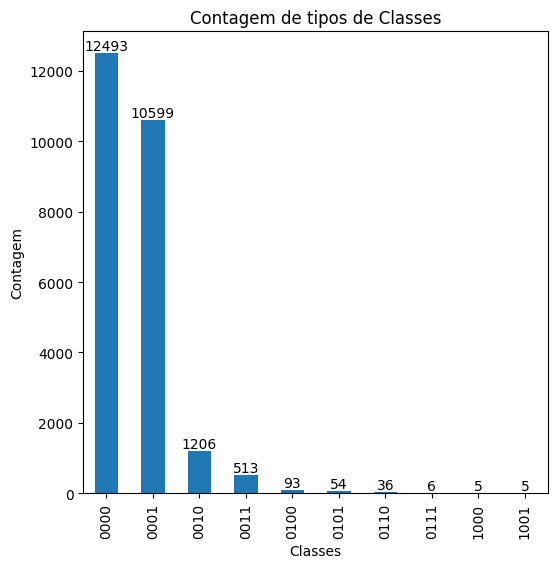

In [9]:
# converter as 4 colunas em uma unica string para contar
y_as_strings = Y.astype(str).agg(''.join, axis=1)
# contagem de diagnosticos 
class_counts = y_as_strings.value_counts().sort_index()

#plota gafico 

plt.figure(figsize=(6,6))
class_counts.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Contagem')
plt.title('Contagem de tipos de Classes')

#adiciona rotulos
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### 4.1 Sumarização estística

In [10]:

def sumarizacao(df):
    # Força a conversão de tudo para numérico, transformando erros em NaN
    df_numeric = df.apply(pd.to_numeric, errors='coerce')
    
    # O Pandas tem um método chamado .describe() que já calcula quase tudo
    summary = df_numeric.describe().T  
    
    stats = []
    for index, row in summary.iterrows():
        # index é o nome da coluna
        stats.append([
            index, 
            round(row['max'], 2), 
            round(row['min'], 2), 
            round(row['mean'], 2), 
            round(row['50%'], 2),
            round(row['std'], 2)
        ])
    
    headers = ['Coluna','Máximo', 'Mínimo', 'Média', 'Mediana', 'Desvio Padrão']
    print(tabulate(stats, headers, tablefmt='grid'))

# Tente rodar agora
sumarizacao(data)

+----------+----------+----------+---------+-----------+-----------------+
|   Coluna |   Máximo |   Mínimo |   Média |   Mediana |   Desvio Padrão |
+==========+==========+==========+=========+===========+=================+
|        0 |        1 |        0 |    0.5  |         1 |            0.5  |
+----------+----------+----------+---------+-----------+-----------------+
|        1 |        1 |        0 |    0.5  |         1 |            0.5  |
+----------+----------+----------+---------+-----------+-----------------+
|        2 |        1 |        0 |    0.38 |         0 |            0.49 |
+----------+----------+----------+---------+-----------+-----------------+
|        3 |        1 |        0 |    0.38 |         0 |            0.49 |
+----------+----------+----------+---------+-----------+-----------------+
|        4 |        1 |        0 |    0.46 |         0 |            0.5  |
+----------+----------+----------+---------+-----------+-----------------+
|        5 |        1 |  

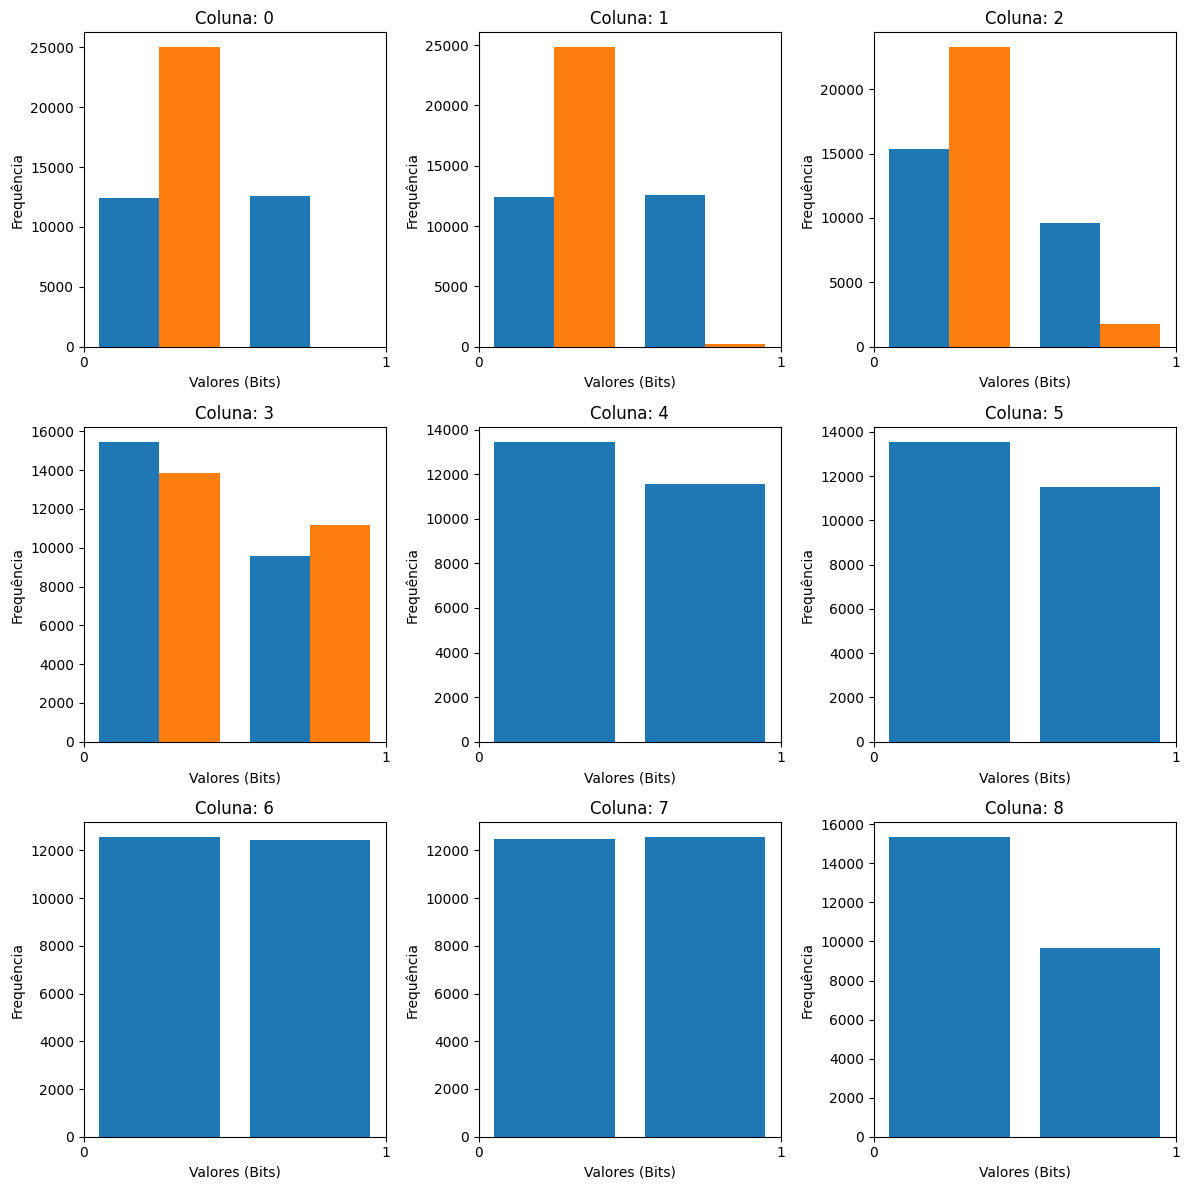

In [11]:
colunas_para_plotar = data.columns[:9] 

fig, axs = plt.subplots(3, 3, figsize=(12, 12), tight_layout=True)

for i, column in enumerate(colunas_para_plotar):
    row = i // 3  
    col = i % 3  

    # Para dados binários, 2 bins (0 e 1) são ideais
    axs[row, col].hist(data[column], bins=2, rwidth=0.8)
    axs[row, col].set_title(f'Coluna: {column}')
    axs[row, col].set_xticks([0, 1]) # Garante que mostre apenas 0 e 1 no eixo X
    axs[row, col].set_xlabel('Valores (Bits)')
    axs[row, col].set_ylabel('Frequência')
    
plt.show()

### 4.2 Detecção de dados faltantes e Interpolação 


In [12]:
# Detecção de dados faltantes 
missing_counts = data.isnull().sum()
print('Total de dados faltantes por atributo:')
print(missing_counts)

Total de dados faltantes por atributo:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
0     0
1     0
2     0
3     0
dtype: int64


In [13]:
def interpolacao(data):
    if data.isnull().values.any():
        data = data.fillna(data.mean()) 
        
        data = data.interpolate(method='nearest')
    return data

In [14]:
if interp_exec:
    data = interpolacao(data)

# verifica novamente os dados
missing_counts = data.isnull().sum()
print('Total de dados faltantes por atributo:')
print(missing_counts)

Total de dados faltantes por atributo:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
0     0
1     0
2     0
3     0
dtype: int64


### 4.6 Exportando ou carregando um dataset tratado

In [15]:

filename_x = 'dataset/x_frames.joblib'
filename_y = 'dataset/y_frames.joblib'

if export_frames or not os.path.exists(filename_x):
    # Converte direto, sem loops lentos
    x_frames = data[x_names].values.astype(np.float32)
    y_frames = data[y_names].values.astype(np.float32)
    
    dump(x_frames, filename_x)
    dump(y_frames, filename_y)
    print("Dataset exportado com sucesso!")
else:
    x_frames = load(filename_x)
    y_frames = load(filename_y)
    print("Dataset carregado do arquivo.")

print(f"X shape: {x_frames.shape}") # Esperado: (N, 30)
print(f"Y shape: {y_frames.shape}") # Esperado: (N, 4)

Dataset exportado com sucesso!
X shape: (25010, 34)
Y shape: (25010, 8)


In [16]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_frames, y_frames, test_size=0.3, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(14005, 34)
(14005, 8)
(3502, 34)
(3502, 8)
(7503, 34)
(7503, 8)


## 5. Treinamento do Modelo

### 5.1 Construção do Modelo

In [17]:
#empilhamento de camadas para construcao da dnn
#parametros da rede
act_function = 'relu'
act_output = 'sigmoid'
drop = 0.1
initializer = tensorflow.keras.initializers.HeNormal()
#camada de entrada
inputs = Input(shape = (x_train.shape[1],), dtype='float32')
#camada 1
layer1 = Dense(32, activation = act_function, kernel_initializer = initializer)(inputs)
layer1 = Dropout(drop)(layer1)

#camada 2
layer2 = Dense(64, activation = act_function, kernel_initializer = initializer)(layer1)
layer2 = Dropout(drop)(layer2)

#camada 3
layer3 = Dense(32, activation = act_function, kernel_initializer = initializer)(layer2)
layer3 = Dropout(drop)(layer3)

#camada de saida
outputs = Dense(y_train.shape[1], activation = act_output, kernel_initializer = initializer)(layer3)

#geracao do modelo
dnn_poker = Model(inputs, outputs)

### 5.2 Inspeção do Modelo 

In [18]:
dnn_poker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 34)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,576 (21.78 KB)

 Trainable params: 5,576 (21.78 KB)

 Non-trainable params: 0 (0.00 B)

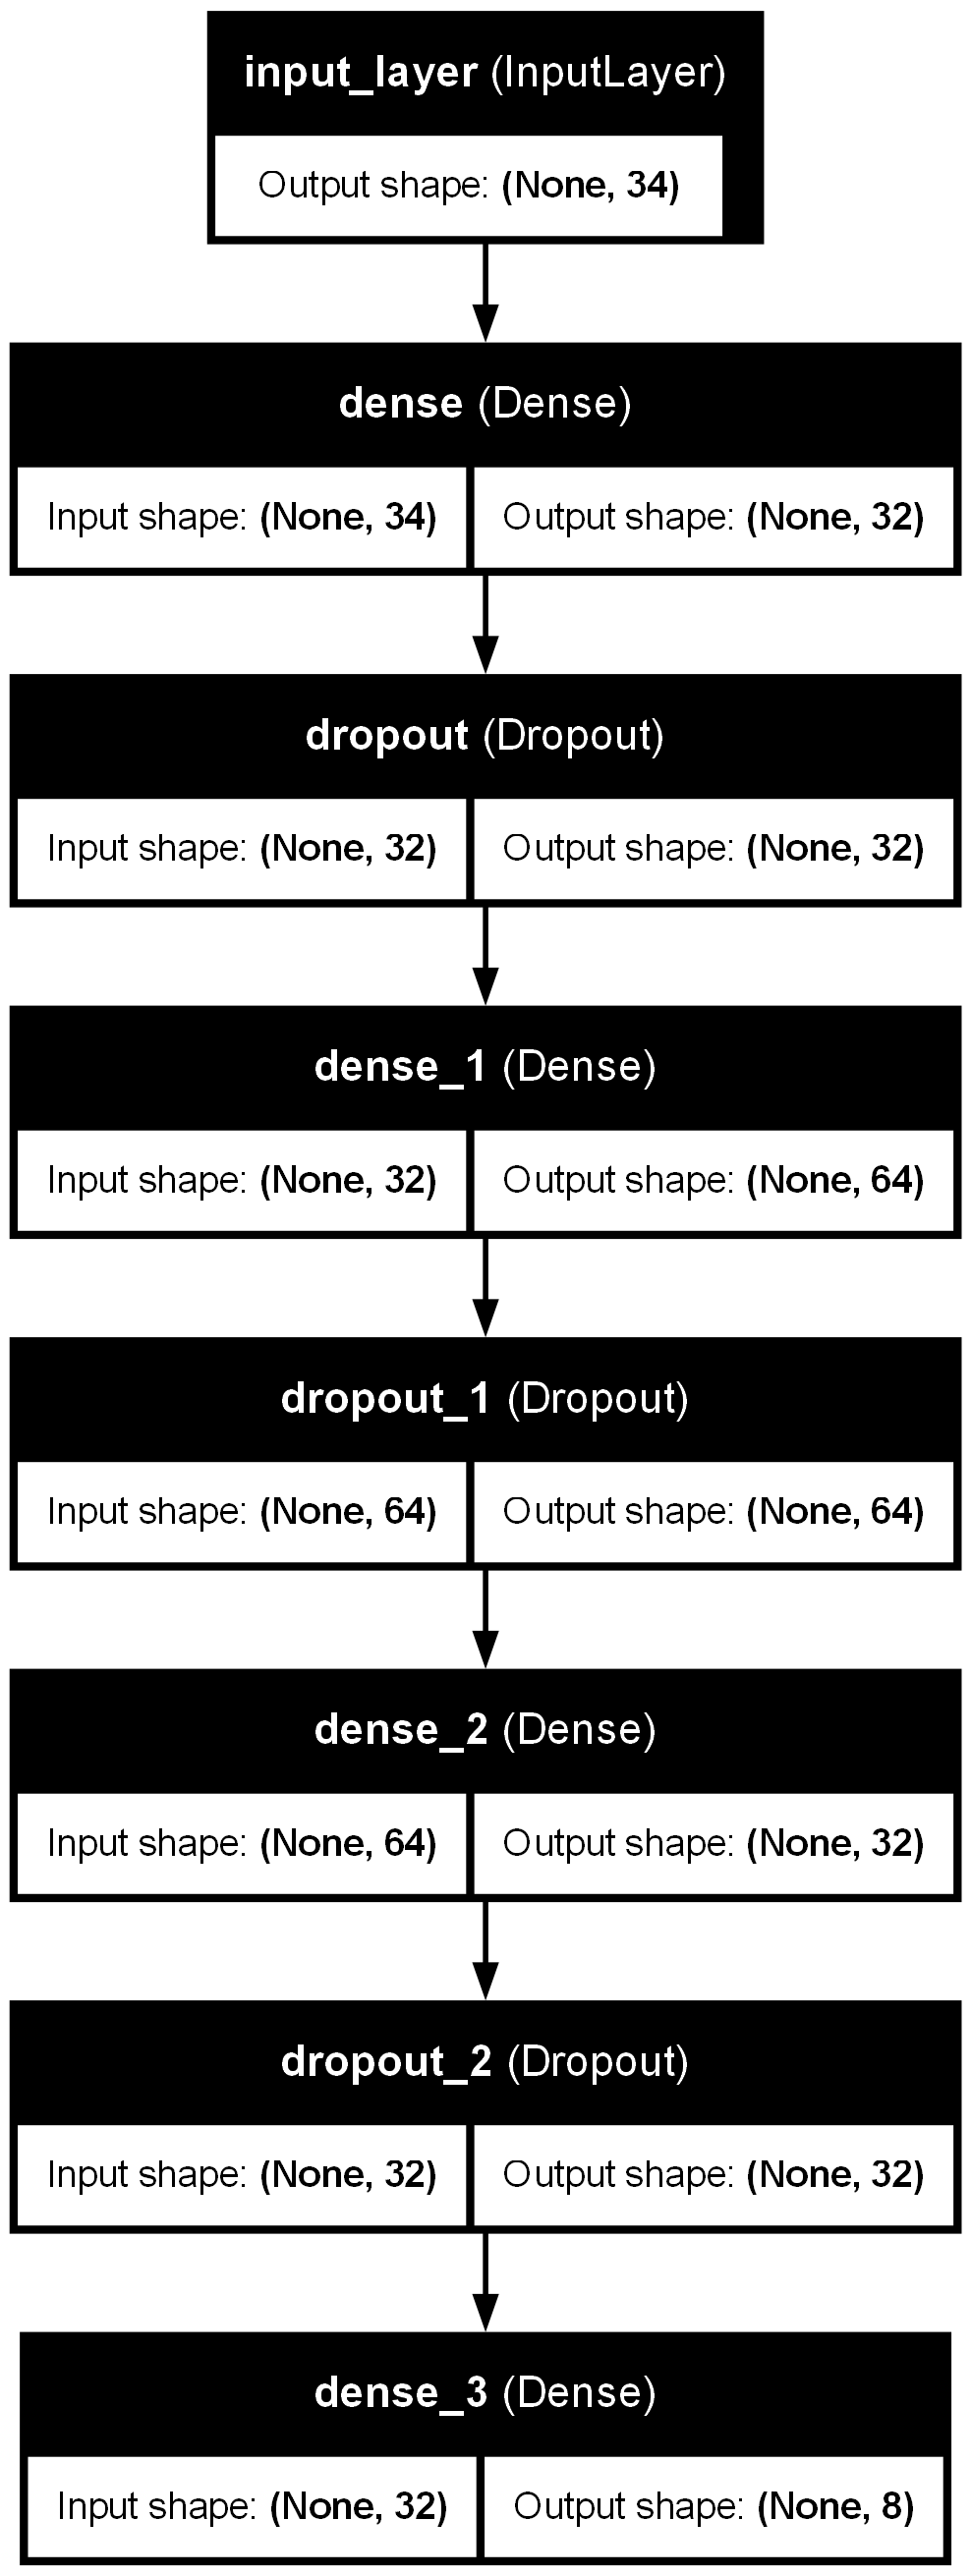

In [19]:
plot_model(dnn_poker, show_shapes=True, show_layer_names=True, rankdir="TB")

### 5.3 Otimização do Modelo

In [20]:
if (new_model):
    opt = Adam(learning_rate = 0.0001)
    dnn_poker.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    cp = ModelCheckpoint(
        filepath = 'models/best_weights.weights.h5', 
        save_weights_only = True,
        monitor = 'val_loss',
        mode = 'min',
        save_best_only = True)
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 100)
    history = dnn_poker.fit(
        x_train, y_train,
        validation_data = (x_val, y_val),
        epochs = 1000,
        verbose = 1,
        callbacks = [es, cp],
        batch_size = 64,
        shuffle = True)
    np.save('models/history_model.npy', history.history)
    dnn_poker.load_weights('models/best_weights.weights.h5')
    dnn_poker.save('models/dnn_poker.keras') 
else:
    dnn_poker = load_model('models/dnn_poker.keras')

Epoch 1/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.5990 - loss: 0.6666 - val_binary_accuracy: 0.7211 - val_loss: 0.5661
Epoch 2/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7170 - loss: 0.5440 - val_binary_accuracy: 0.7538 - val_loss: 0.4815
Epoch 3/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7473 - loss: 0.4809 - val_binary_accuracy: 0.7892 - val_loss: 0.4350
Epoch 4/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7696 - loss: 0.4469 - val_binary_accuracy: 0.8186 - val_loss: 0.4035
Epoch 5/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7922 - loss: 0.4191 - val_binary_accuracy: 0.8484 - val_loss: 0.3690
Epoch 6/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8169 - loss: 0.3885 - val_binary_accuracy: 0.8780 - val_loss: 0.3302
Epoch 7/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.8437 - loss: 0.3528 - val_binary_accuracy: 0.9041 - val_loss:

In [21]:
pygame.mixer.init()
arquivo_mp3 = 'support_files/mario_coin.mp3'
pygame.mixer.music.load(arquivo_mp3)
pygame.mixer.music.play()
while pygame.mixer.music.get_busy():
    continue
print('Sucesso!')

Sucesso!


## 6. Avaliando a Qualidade do Treino 

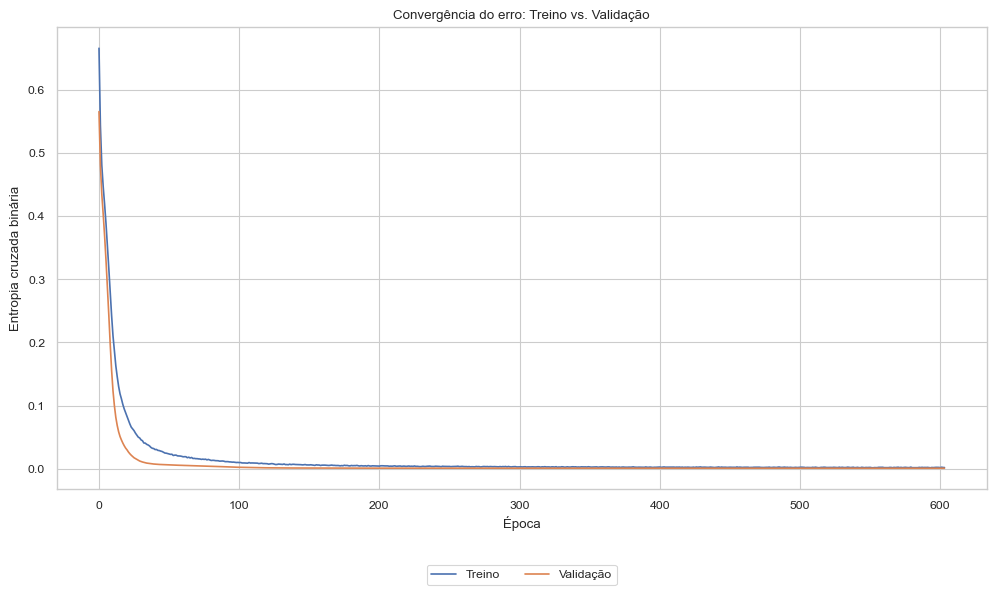

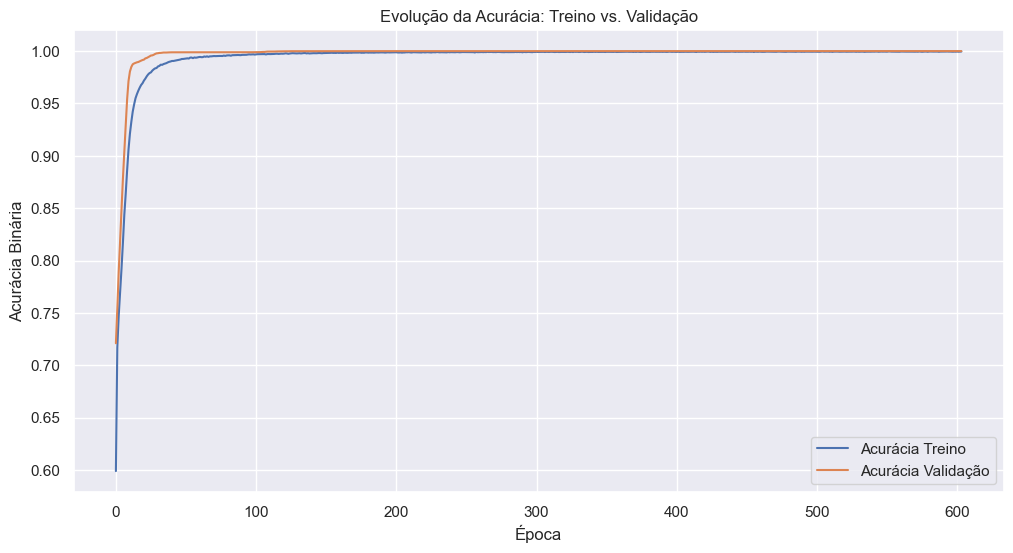

In [22]:
history = np.load('models/history_model.npy', allow_pickle = True).item()
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')
train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'Entropia cruzada binária'

fig = plt.figure()
plt.plot(train_metric, label = 'Treino')
plt.plot(valid_metric, label = 'Validação')
plt.ylabel(name_metric)
plt.xlabel('Época')
plt.title('Convergência do erro: Treino vs. Validação')
plt.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, shadow = False, ncol = 2)
plt.show()

# Adicione isso logo após o seu gráfico de Loss
sns.set(rc={'figure.figsize':(12, 6)})
train_acc = history['binary_accuracy']
valid_acc = history['val_binary_accuracy']

plt.figure()
plt.plot(train_acc, label = 'Acurácia Treino')
plt.plot(valid_acc, label = 'Acurácia Validação')
plt.ylabel('Acurácia Binária')
plt.xlabel('Época')
plt.title('Evolução da Acurácia: Treino vs. Validação')
plt.legend(loc = 'lower right')
plt.show()

## 7. Testando Previsões 

### 7.1 Gerando as previsões com o modelo treinado

In [23]:
y_hat = dnn_poker.predict(x_test)
y_hat, y_test = (y_hat > 0.5, y_test > 0.5)

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### 7.2. Calculando a taxa de acerto com base na matriz de confusão

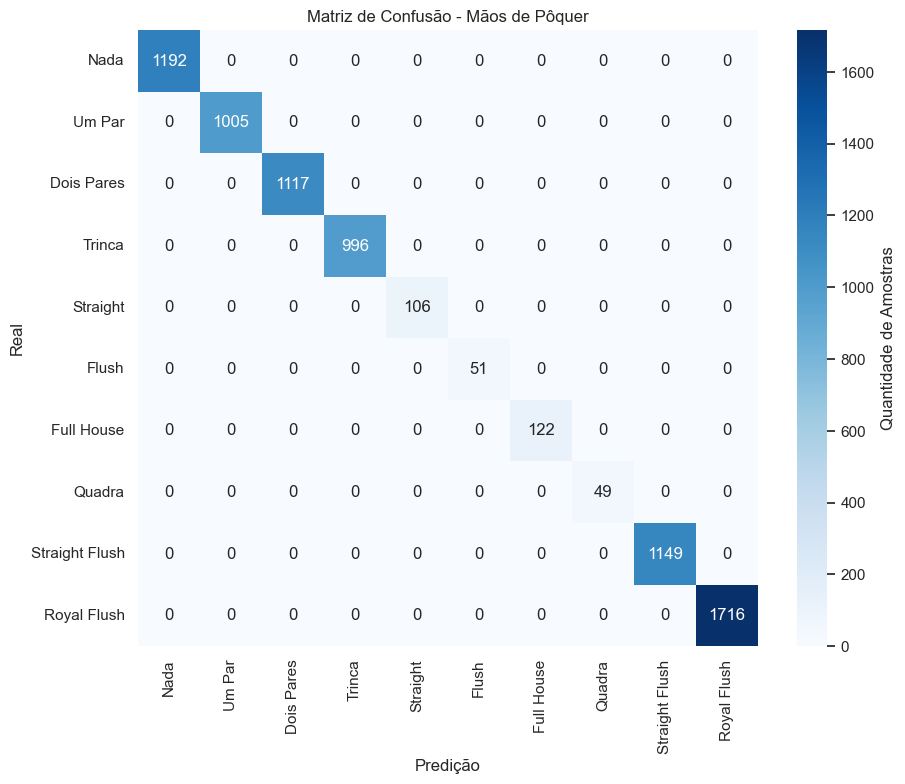

In [31]:

# 1. Converter saídas para inteiros (0 ou 1)
y_hat_bits = (y_hat > 0.5).astype(int)
y_test_bits = np.array(y_test).astype(int)

# 2. Como vimos que há 8 colunas, vamos garantir que pegamos apenas as 4 últimas
# Geralmente, as mãos de 0-9 ficam nos últimos 4 bits (LSB)
if y_test_bits.shape[1] == 8:
    y_test_bits = y_test_bits[:, -4:]
    y_hat_bits = y_hat_bits[:, -4:]

# 3. Converter para decimal usando pesos de 4 bits (8, 4, 2, 1)
pesos = np.array([8, 4, 2, 1])
y_test_dec = np.dot(y_test_bits, pesos)
y_hat_dec = np.dot(y_hat_bits, pesos)

# 4. Forçar os valores para ficarem entre 0 e 9 (caso a rede preveja algo maior)
y_test_dec = np.clip(y_test_dec, 0, 9)
y_hat_dec = np.clip(y_hat_dec, 0, 9)

# 5. Nomes reais das mãos
maos_poker = ['Nada', 'Um Par', 'Dois Pares', 'Trinca', 'Straight', 
              'Flush', 'Full House', 'Quadra', 'Straight Flush', 'Royal Flush']

# 6. Plotar apenas o que interessa (10x10)
cm = confusion_matrix(y_test_dec, y_hat_dec, labels=range(10))

plt.figure(figsize=(10, 8))
# Usamos 'mask' para não mostrar zeros e limpar o visual
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=maos_poker, yticklabels=maos_poker,
            cbar_kws={'label': 'Quantidade de Amostras'})

plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Mãos de Pôquer')
plt.show()

In [35]:
#calcula a acuracia
accuracy = np.trace(cm)/np.sum(cm)
accuracy_percent = round(accuracy * 100, 2)
print("Taxa de Acerto: {:.2f}%".format(accuracy_percent))

Taxa de Acerto: 100.00%


### Teste final de CLASSIFICAÇÃO

In [ ]:

# 2. Selecionar índices aleatórios do conjunto de teste
# pegar 3 exemplos aleatórios para testar
indices_aleatorios = np.random.choice(len(x_test), 3, replace=False)

print(f"{'TESTE DE CLASSIFICAÇÃO INDIVIDUAL':^60}")
print("="*60)

for idx in indices_aleatorios:
    # Selecionar a mão (X) e o gabarito (y)
    mao_input = x_test[idx:idx+1]
    gabarito_bits = y_test[idx]
    
    # Fazer a previsão
    pred_probs = dnn_poker.predict(mao_input, verbose=0)
    pred_bits = (pred_probs > 0.5).astype(int)[0]
    

    pesos = np.array([8, 4, 2, 1])
    bits_para_calc = pred_bits[-4:] 
    bits_reais_para_calc = gabarito_bits[-4:].astype(int)
    
    classe_pred_idx = np.dot(bits_para_calc, pesos)
    classe_real_idx = np.dot(bits_reais_para_calc, pesos)
    
    # Garantir que o índice não ultrapasse a lista de nomes
    classe_pred_idx = min(classe_pred_idx, 9)
    classe_real_idx = min(classe_real_idx, 9)

    # Exibir resultados
    print(f"MÃO TESTADA (Índice {idx})")
    print(f"Real: {maos_poker[classe_real_idx]}")
    print(f"Previsto: {maos_poker[classe_pred_idx]}")
    
    status = "ACERTOU" if classe_pred_idx == classe_real_idx else "ERROU"
    print(f"Resultado: {status}")
    print("-" * 60)

             TESTE DE CLASSIFICAÇÃO INDIVIDUAL              
MÃO TESTADA (Índice 567)
Real: Straight Flush
Previsto: Straight Flush
Resultado: ACERTOU
------------------------------------------------------------
MÃO TESTADA (Índice 4499)
Real: Royal Flush
Previsto: Royal Flush
Resultado: ACERTOU
------------------------------------------------------------
MÃO TESTADA (Índice 5354)
Real: Straight Flush
Previsto: Straight Flush
Resultado: ACERTOU
------------------------------------------------------------
